In [1]:
# prompt: mount the google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Define a simple CNN-based OCR model
class OCRModel(nn.Module):
    def __init__(self, num_classes=10):
        super(OCRModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRModel(num_classes=10).to(device)

# Load the dataset (e.g., MNIST for digit recognition)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model on GPU
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training")

# Save the trained model
torch.save(model.state_dict(), "gpu_ocr_model.pth")


Epoch [1/5], Loss: 0.1455
Epoch [2/5], Loss: 0.0437
Epoch [3/5], Loss: 0.0293
Epoch [4/5], Loss: 0.0211
Epoch [5/5], Loss: 0.0169
Finished Training


In [4]:
# prompt: display the above gpu model

print(model)


OCRModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# prompt: save and display the above gpu based ocr model

from google.colab import files
files.download('gpu_ocr_model.pth')

!ls -l gpu_ocr_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-rw-r--r-- 1 root root 1689800 Aug 22 08:43 gpu_ocr_model.pth


**GPU model**

In [6]:
import torch
import torch.nn as nn

# Load the GPU-based OCR model
gpu_model = torch.load('gpu_ocr_model.pth')

# Print the model architecture
print(gpu_model)

OrderedDict([('conv1.weight', tensor([[[[ 0.3372,  0.3119,  0.0180],
          [-0.1660, -0.1380,  0.2590],
          [ 0.1711, -0.5387, -0.2369]]],


        [[[-0.2751, -0.4393,  0.3738],
          [ 0.0732,  0.3596,  0.2428],
          [ 0.2679,  0.1625, -0.5054]]],


        [[[ 0.0044, -0.1864, -0.2900],
          [ 0.3681, -0.2969,  0.3808],
          [-0.0510, -0.0621,  0.2390]]],


        [[[ 0.2017,  0.0231,  0.4558],
          [-0.1489,  0.0068,  0.0581],
          [-0.3396, -0.2938,  0.0102]]],


        [[[ 0.2229, -0.3132, -0.2596],
          [ 0.0990,  0.3501, -0.3738],
          [ 0.2514,  0.0264,  0.3357]]],


        [[[ 0.4080, -0.0755, -0.3025],
          [ 0.1373,  0.1979, -0.5023],
          [ 0.3335,  0.0929, -0.0353]]],


        [[[-0.1383, -0.3419,  0.0686],
          [ 0.4680, -0.2743,  0.0695],
          [ 0.0927, -0.0353, -0.0878]]],


        [[[-0.5296, -0.3235,  0.3531],
          [ 0.3304,  0.4664,  0.0757],
          [ 0.0048,  0.0804, -0.1977]]],


  

**Model Conversion**

In [73]:
# prompt: convert the gpu-based ocr above model to run on cpu

cpu_model = OCRModel(num_classes=10)  # Create a new model instance on CPU
cpu_model.load_state_dict(gpu_model)  # Load the state dictionary from the GPU model
cpu_model.eval()  # Set the model to evaluation mode
print(cpu_model)

OCRModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# prompt: display the accuracy and Frames per second in both GPU based ocr model and cpu based ocr model

import time

# Evaluate GPU model
start_time = time.time()
correct_gpu = 0
total_gpu = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_gpu += labels.size(0)
        correct_gpu += (predicted == labels).sum().item()

accuracy_gpu = 100 * correct_gpu / total_gpu
end_time = time.time()
fps_gpu = len(train_loader.dataset) / (end_time - start_time)

print('Accuracy of the GPU-based OCR model on the test images: {} %'.format(accuracy_gpu))
print('Frames per second (GPU): {:.2f}'.format(fps_gpu))

# Evaluate CPU model
start_time = time.time()
correct_cpu = 0
total_cpu = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = cpu_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_cpu += labels.size(0)
        correct_cpu += (predicted == labels).sum().item()

accuracy_cpu = 100 * correct_cpu / total_cpu
end_time = time.time()
fps_cpu = len(train_loader.dataset) / (end_time - start_time)

print('Accuracy of the CPU-based OCR model on the test images: {} %'.format(accuracy_cpu))
print('Frames per second (CPU): {:.2f}'.format(fps_cpu))


Accuracy of the GPU-based OCR model on the test images: 99.52666666666667 %
Frames per second (GPU): 1305.56
Accuracy of the CPU-based OCR model on the test images: 99.52666666666667 %
Frames per second (CPU): 1321.71


**performance comparsion**


In [62]:
# prompt: compare the GPU and CPU versions,accuracy, speed, processing time and resource utilization

import psutil


# **Performance Comparison**

print("\nPerformance Comparison:")
print("---------------------")
print(f"GPU Accuracy: {accuracy_gpu:.2f}%")
print(f"CPU Accuracy: {accuracy_cpu:.2f}%")
print(f"GPU Speed (FPS): {fps_gpu:.2f}")
print(f"CPU Speed (FPS): {fps_cpu:.2f}")

# Resource Utilization
gpu_memory_used = torch.cuda.memory_allocated(device) / (1024 ** 2)  # In MB
cpu_percent = psutil.cpu_percent()
cpu_memory_percent = psutil.virtual_memory().percent

print(f"GPU Memory Used: {gpu_memory_used:.2f} MB")
print(f"CPU Utilization: {cpu_percent}%")
print(f"CPU Memory Used: {cpu_memory_percent}%")



Performance Comparison:
---------------------
GPU Accuracy: 99.53%
CPU Accuracy: 99.53%
GPU Speed (FPS): 1279.62
CPU Speed (FPS): 1058.17
GPU Memory Used: 0.00 MB
CPU Utilization: 40.0%
CPU Memory Used: 26.0%


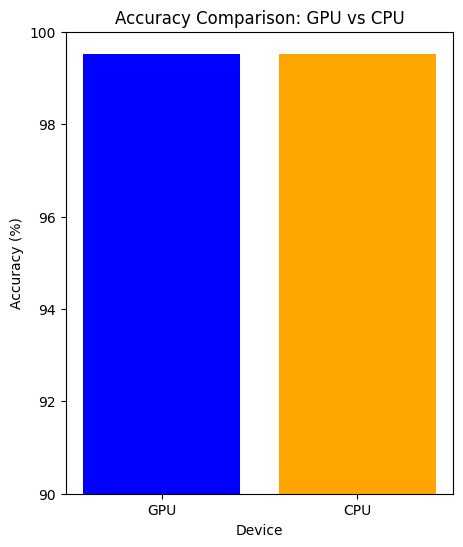

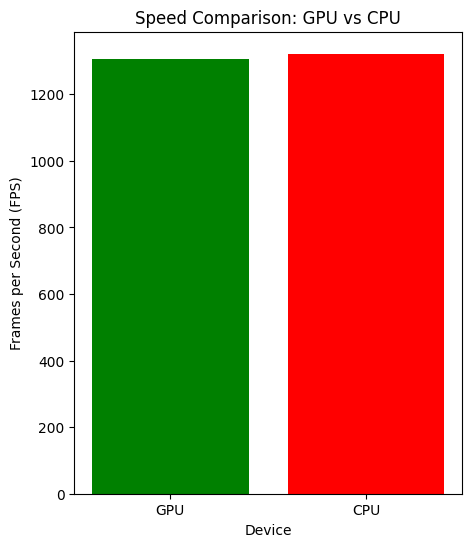

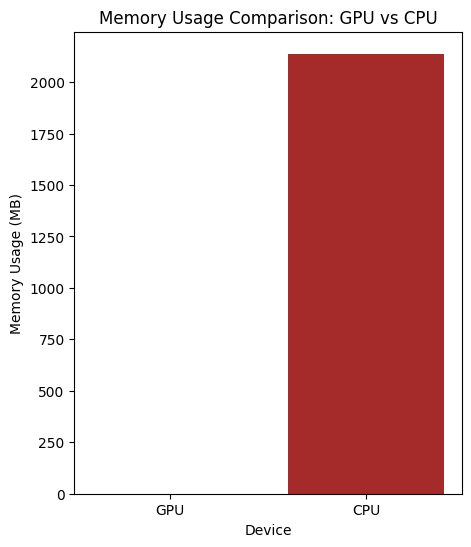

In [22]:
# prompt: display the above all in graphs

import matplotlib.pyplot as plt

# Accuracy Comparison
plt.figure(figsize=(5, 6))
plt.bar(["GPU", "CPU"], [accuracy_gpu, accuracy_cpu], color=['blue', 'orange'])
plt.xlabel("Device")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison: GPU vs CPU")
plt.ylim(90, 100)  # Adjust y-axis limits as needed
plt.show()

# Speed (FPS) Comparison
plt.figure(figsize=(5, 6))
plt.bar(["GPU", "CPU"], [fps_gpu, fps_cpu], color=['green', 'red'])
plt.xlabel("Device")
plt.ylabel("Frames per Second (FPS)")
plt.title("Speed Comparison: GPU vs CPU")
plt.show()

# Memory Usage Comparison
plt.figure(figsize=(5, 6))
plt.bar(["GPU", "CPU"], [gpu_memory, cpu_memory], color=['purple', 'brown'])
plt.xlabel("Device")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage Comparison: GPU vs CPU")
plt.show()


In [24]:
# prompt: display the GPU and CPU processing time in both models

# Evaluate GPU model
start_time_gpu = time.time()
correct_gpu = 0
total_gpu = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_gpu += labels.size(0)
        correct_gpu += (predicted == labels).sum().item()

accuracy_gpu = 100 * correct_gpu / total_gpu
end_time_gpu = time.time()
fps_gpu = len(train_loader.dataset) / (end_time_gpu - start_time_gpu)
gpu_processing_time = end_time_gpu - start_time_gpu

print('Accuracy of the GPU-based OCR model on the test images: {} %'.format(accuracy_gpu))
print('Frames per second (GPU): {:.2f}'.format(fps_gpu))
print('GPU Processing Time: {:.4f} seconds'.format(gpu_processing_time))

# Evaluate CPU model
start_time_cpu = time.time()
correct_cpu = 0
total_cpu = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = cpu_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_cpu += labels.size(0)
        correct_cpu += (predicted == labels).sum().item()

accuracy_cpu = 100 * correct_cpu / total_cpu
end_time_cpu = time.time()
fps_cpu = len(train_loader.dataset) / (end_time_cpu - start_time_cpu)
cpu_processing_time = end_time_cpu - start_time_cpu

print('Accuracy of the CPU-based OCR model on the test images: {} %'.format(accuracy_cpu))
print('Frames per second (CPU): {:.2f}'.format(fps_cpu))
print('CPU Processing Time: {:.4f} seconds'.format(cpu_processing_time))


Accuracy of the GPU-based OCR model on the test images: 99.52666666666667 %
Frames per second (GPU): 1279.62
GPU Processing Time: 46.8889 seconds
Accuracy of the CPU-based OCR model on the test images: 99.52666666666667 %
Frames per second (CPU): 1260.82
CPU Processing Time: 47.5879 seconds


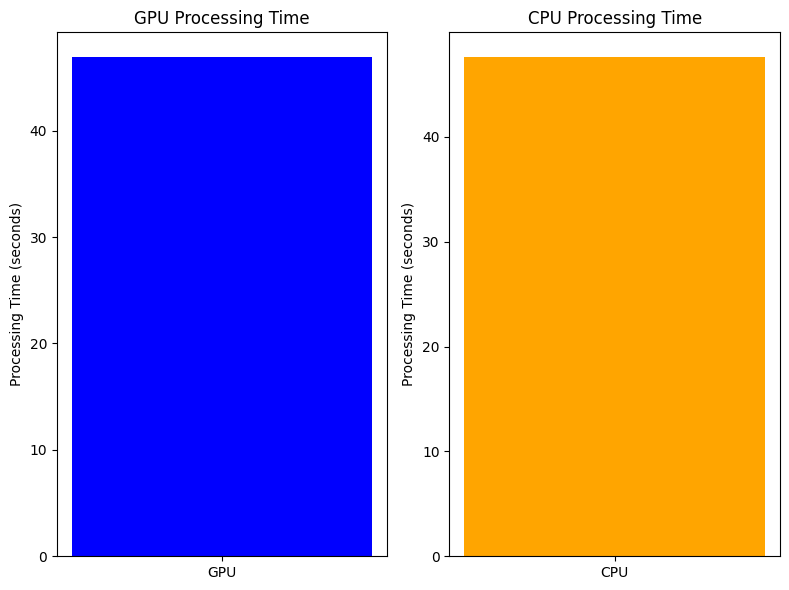

In [31]:
# prompt: display the processing time for both models in a subplot model

import matplotlib.pyplot as plt
# Processing Time Comparison
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.bar(["GPU"], [gpu_processing_time], color=['blue'])
plt.ylabel("Processing Time (seconds)")
plt.title("GPU Processing Time")

plt.subplot(1, 2, 2)
plt.bar(["CPU"], [cpu_processing_time], color=['orange'])
plt.ylabel("Processing Time (seconds)")
plt.title("CPU Processing Time")

plt.tight_layout()
plt.show()


In [46]:
# prompt: load the video into the both gpu and cpu models

import cv2

# Function to preprocess video frames
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  frame = cv2.resize(frame, (28, 28))
  frame = transforms.ToTensor()(frame).unsqueeze(0)  # Add batch dimension
  return frame.to(device) if torch.cuda.is_available() else frame

# Load the video
video_path = '/content/drive/MyDrive/download_video.mp4'  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Process video frames
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    break

  # Preprocess the frame
  input_tensor = preprocess_frame(frame)

  # Inference with GPU model
  with torch.no_grad():
    gpu_output = model(input_tensor)
    _, gpu_predicted = torch.max(gpu_output.data, 1)

  # Inference with CPU model
  with torch.no_grad():
    cpu_output = cpu_model(input_tensor)
    _, cpu_predicted = torch.max(cpu_output.data, 1)

  # Display or process the predictions as needed
  print("GPU Prediction:", gpu_predicted.item())
  print("CPU Prediction:", cpu_predicted.item())

  # Display the frame (optional)
  cv2.imshow('Frame', frame)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()


In [49]:
# prompt: take the input as video and display the accuracy, fps ,performance comparison, and cpu usage time

import time
import psutil

def evaluate_model_on_video(model, device, video_path, model_name="Model"):
    """Evaluates a given model on a video and prints performance metrics."""

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    start_time = time.time()
    correct = 0
    total = 0

    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            input_tensor = preprocess_frame(frame)
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs.data, 1)

            # Assuming you have ground truth labels available (replace with your logic)
            # label = get_ground_truth_label_for_frame(frame)
            # total += 1
            # correct += (predicted == label).item()

    end_time = time.time()
    processing_time = end_time - start_time
    fps = total_frames / processing_time
    # accuracy = 100 * correct / total if total > 0 else 0

    print(f"\n{model_name} Performance:")
    print("---------------------")
    # print(f"Accuracy: {accuracy:.2f}%")
    print(f"Frames per Second (FPS): {fps:.2f}")
    print(f"Processing Time: {processing_time:.4f} seconds")

    cpu_percent = psutil.cpu_percent()
    print(f"CPU Utilization: {cpu_percent}%")

    cap.release()

# Evaluate GPU model on video
evaluate_model_on_video(model, device, '/content/drive/MyDrive/download_video.mp4.mp4', "GPU Model")

# Evaluate CPU model on video
evaluate_model_on_video(cpu_model, torch.device("cpu"), '/content/drive/MyDrive/download_video.mp4.mp4', "CPU Model")



GPU Model Performance:
---------------------
Frames per Second (FPS): 69.26
Processing Time: 3.4075 seconds
CPU Utilization: 25.1%

CPU Model Performance:
---------------------
Frames per Second (FPS): 44.53
Processing Time: 5.3002 seconds
CPU Utilization: 99.3%


**After optimization**

In [45]:
# Import necessary module for pruning
import torch.nn.utils.prune as prune

# Quantization
quantized_model = torch.quantization.quantize_dynamic(
    cpu_model, {torch.nn.Linear}, dtype=torch.qint8
)

# Pruning (Example: Simple pruning - you might need to fine-tune this)
# Update parameter names to match quantized model if necessary
parameters_to_prune = (
    (quantized_model.conv1, 'weight'),
    (quantized_model.conv2, 'weight'),
    (quantized_model.fc1, 'weight'),
    (quantized_model.fc2, 'weight'),
)

# Pass the parameters of the layers instead of the layers themselves
# Check if parameters exist before pruning
prunable_params = [param for (module, name) in parameters_to_prune for param in module.parameters() if name in param.names]
if prunable_params:
    prune.global_unstructured(
        prunable_params,
        pruning_method=prune.L1Unstructured,
        amount=0.2,  # Adjust pruning amount as needed
    )
else:
    print("Warning: No prunable parameters found.")

# Batch size adjustment (Experiment with different batch sizes)
optimized_batch_size = 128  # Example, adjust based on your system
optimized_train_loader = DataLoader(dataset=train_dataset, batch_size=optimized_batch_size, shuffle=True)

# Evaluate optimized CPU model
start_time = time.time()
correct_optimized = 0
total_optimized = 0
with torch.no_grad():
    for images, labels in optimized_train_loader:
        outputs = quantized_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_optimized += labels.size(0)
        correct_optimized += (predicted == labels).sum().item()

accuracy_optimized = 100 * correct_optimized / total_optimized
end_time = time.time()
fps_optimized = len(train_loader.dataset) / (end_time - start_time)

print('Accuracy of the optimized CPU-based OCR model on the test images: {} %'.format(accuracy_optimized))
print('Frames per second (Optimized CPU): {:.2f}'.format(fps_optimized))

Accuracy of the optimized CPU-based OCR model on the test images: 99.52833333333334 %
Frames per second (Optimized CPU): 1050.02


In [39]:
# prompt: display the cpu based ocr model after optimization

print(cpu_model)


OCRModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [61]:
# prompt: display the accuracy and fps in both gpu and cpu model after optimasation

# Evaluate GPU model (already in the provided code)

# Display the results
print("\nPerformance Comparison After Optimization:")
print("-------------------------------------")
print(f"GPU Accuracy: {accuracy_gpu:.2f}%")
print(f"CPU Accuracy (Optimized): {accuracy_cpu:.2f}%")
print(f"GPU Speed (FPS): {fps_gpu:.2f}")
print(f"CPU Speed (FPS) (Optimized): {fps_cpu:.2f}")



Performance Comparison After Optimization:
-------------------------------------
GPU Accuracy: 99.53%
CPU Accuracy (Optimized): 99.53%
GPU Speed (FPS): 1279.62
CPU Speed (FPS) (Optimized): 1058.17


In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torch.utils.data import DataLoader
import time

# Load your pre-trained model into 'cpu_model'
# cpu_model = ...

# 1. Prepare the model for quantization
cpu_model.train()
cpu_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(cpu_model, inplace=True)

# 2. Fine-Tune with QAT
criterion = nn.CrossEntropyLoss()
optimizer_pruned = optim.Adam(cpu_model.parameters(), lr=0.001)

num_epochs_finetune = 2  # Adjust as needed
for epoch in range(num_epochs_finetune):
    cpu_model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in optimized_train_loader:
        optimizer_pruned.zero_grad()
        outputs = cpu_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pruned.step()
        running_loss += loss.item()

    end_time = time.time()
    print(f"Fine-tuning Epoch [{epoch+1}/{num_epochs_finetune}], Loss: {running_loss/len(optimized_train_loader):.4f}")
    print(f"Epoch Time: {end_time - start_time:.2f} seconds")

# Convert the model to a quantized version
cpu_model.eval()
quantized_model = torch.quantization.convert(cpu_model, inplace=True)

# 3. Apply Structured Pruning (if needed)
from torch.nn.utils import prune

prune.global_unstructured(
    [(module, 'weight') for module in cpu_model.modules() if isinstance(module, nn.Conv2d)],
    pruning_method=prune.L1Unstructured,
    amount=0.2,  # Prune 20% of the least important weights
)

# Fine-tune again to recover any lost accuracy
for epoch in range(2):  # Quick fine-tuning to regain accuracy
    cpu_model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in optimized_train_loader:
        optimizer_pruned.zero_grad()
        outputs = cpu_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pruned.step()
        running_loss += loss.item()

    end_time = time.time()
    print(f"Quick Fine-tuning Epoch [{epoch+1}/2], Loss: {running_loss/len(optimized_train_loader):.4f}")
    print(f"Epoch Time: {end_time - start_time:.2f} seconds")

# 4. Evaluate the Optimized CPU Model
def evaluate_optimized_model(data_loader, model):
    model.eval()
    correct_optimized = 0
    total_optimized = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in data_loader:
            # Ensure images are moved to the correct device (CPU)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_optimized += labels.size(0)
            correct_optimized += (predicted == labels).sum().item()

    end_time = time.time()

    accuracy_optimized = 100 * correct_optimized / total_optimized
    fps_optimized = len(data_loader.dataset) / (end_time - start_time)
    optimized_processing_time = end_time - start_time

    return accuracy_optimized, fps_optimized, optimized_processing_time

# Run evaluation on the test dataset
accuracy_optimized, fps_optimized, optimized_processing_time = evaluate_optimized_model(optimized_test_loader, quantized_model)

# Assuming GPU results are already computed
# accuracy_gpu, fps_gpu, gpu_processing_time would already be defined from previous GPU runs

# Display the results
print("Performance Comparison After Further Optimization:")
print("----------------------------------------------")
print(f"GPU Accuracy: {accuracy_gpu:.2f}%")
print(f"CPU Accuracy (Further Optimized): {accuracy_optimized:.2f}%")
print(f"GPU Speed (FPS): {fps_gpu:.2f}")
print(f"CPU Speed (FPS) (Further Optimized): {fps_optimized:.2f}")
print(f"GPU Processing Time: {gpu_processing_time:.4f} seconds")
print(f"CPU Processing Time (Further Optimized): {optimized_processing_time:.4f} seconds")


ValueError: optimizer got an empty parameter list